In [3]:
# ===========================================
# CELL 1: Basic setup, imports, paths
# ===========================================
!pip install -q --upgrade scikit-learn

from google.colab import drive
drive.mount("/content/drive")

import os
import random
import time
import pickle
from io import BytesIO
from pathlib import Path

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Project paths (UPDATED ROOT)
PROJECT_ROOT = Path("/content/drive/MyDrive/Cal_Estimation_Project")
N5K_ROOT     = PROJECT_ROOT / "data" / "raw" / "nutrition5k"

GEOMETRY_CSV    = PROJECT_ROOT / "cache" / "geometry_features.csv"
VISUAL_CSV      = PROJECT_ROOT / "cache" / "visual_features.csv"
DISHES_XLSX     = N5K_ROOT / "dishes.xlsx"
DISH_IMAGES_PKL = N5K_ROOT / "dish_images.pkl"

OUTPUT_DIR   = PROJECT_ROOT / "Outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# NEW: cache dir + helper
CACHE_DIR = PROJECT_ROOT / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

def save_cache(obj, name: str):
    path = CACHE_DIR / f"{name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(obj, f)
    print(f"✔ Saved cache → {path}")

# Cache file for predictions (to avoid retraining)
PRED_PATH  = OUTPUT_DIR / "nutrition5k_dual_branch_predictions.csv"
MODEL_PATH = OUTPUT_DIR / "nutrition5k_dual_branch_model.pth"

print("Project root:", PROJECT_ROOT)
print("Output dir  :", OUTPUT_DIR)
print("Geometry CSV exists:", GEOMETRY_CSV.exists())
print("Visual   CSV exists:", VISUAL_CSV.exists())
print("Dishes  XLSX exists:", DISHES_XLSX.exists())
print("dish_images.pkl exists:", DISH_IMAGES_PKL.exists())
print("Cached prediction file exists:", PRED_PATH.exists())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.6 MB/s eta 0:00:00
Mounted at /content/drive
Using device: cuda
Project root: /content/drive/MyDrive/Cal_Estimation_Project
Output dir  : /content/drive/MyDrive/Cal_Estimation_Project/Outputs
Geometry CSV exists: True
Visual   CSV exists: True
Dishes  XLSX exists: True
dish_images.pkl exists: True
Cached prediction file exists: True


In [4]:
# ===========================================
# CELL 2: Load metadata and feature tables
# ===========================================
# 1) Load dishes metadata (has mass, calories, macros)
dishes_df = pd.read_excel(DISHES_XLSX)
print("Raw dishes_df:", dishes_df.shape)
print("dishes_df columns:", list(dishes_df.columns))

# Normalize meta columns for targets
meta = dishes_df.copy()
meta = meta.rename(columns={
    "dish_id": "dish_id",
    "total_mass": "true_mass_g",
    "total_calories": "true_calories_kcal"
})
keep_meta_cols = ["dish_id"]
if "true_mass_g" in meta.columns:
    keep_meta_cols.append("true_mass_g")
if "true_calories_kcal" in meta.columns:
    keep_meta_cols.append("true_calories_kcal")

meta = meta[keep_meta_cols].copy()
meta["dish_id"] = meta["dish_id"].astype(str)
print("Normalized meta:", meta.shape)
print("meta columns:", list(meta.columns))

# 2) Load geometry features (MiDaS and segmentation based)
geometry_df = pd.read_csv(GEOMETRY_CSV)
geometry_df["dish_id"] = geometry_df["dish_id"].astype(str)
print("geometry_df:", geometry_df.shape)
print("geometry_df columns:", list(geometry_df.columns))

# 3) Load visual features (color stats + CLIP/ViT PCs)
visual_df = pd.read_csv(VISUAL_CSV)
visual_df["dish_id"] = visual_df["dish_id"].astype(str)
print("visual_df:", visual_df.shape)
print("visual_df columns:", list(visual_df.columns))

# 4) Load dish_images.pkl (RGB and depth bytes)
dish_images_df = pd.read_pickle(DISH_IMAGES_PKL)
print("dish_images_df:", dish_images_df.shape)
print("dish_images_df columns:", list(dish_images_df.columns))

# Make sure dish id is string
dish_images_df["dish"] = dish_images_df["dish"].astype(str)
dish_ids_with_img = set(dish_images_df["dish"].unique())
print("Unique dishes with images:", len(dish_ids_with_img))


Raw dishes_df: (5006, 6)
dishes_df columns: ['dish_id', 'total_mass', 'total_calories', 'total_fat', 'total_carb', 'total_protein']
Normalized meta: (5006, 3)
meta columns: ['dish_id', 'true_mass_g', 'true_calories_kcal']
geometry_df: (3195, 13)
geometry_df columns: ['dish_id', 'true_mass_g', 'true_calories_kcal', 'area_px', 'midas_volume', 'mean_height', 'median_height', 'max_height', 'std_height', 'avg_hue', 'avg_sat', 'avg_val', 'std_val']
visual_df: (3195, 16)
visual_df columns: ['dish_id', 'vis_pc1', 'vis_pc2', 'vis_pc3', 'vis_pc4', 'vis_pc5', 'vis_pc6', 'vis_pc7', 'vis_pc8', 'vis_pc9', 'vis_pc10', 'vis_pc11', 'vis_pc12', 'vis_pc13', 'vis_pc14', 'vis_pc15']
dish_images_df: (3490, 3)
dish_images_df columns: ['dish', 'rgb_image', 'depth_image']
Unique dishes with images: 3490


In [5]:
# ===========================================
# CELL 3: Merge feature tables and targets
# ===========================================
print("Merging geometry + visual on dish_id...")
df = geometry_df.merge(visual_df, on="dish_id", how="inner")
print("After geometry + visual merge:", df.shape)

# Merge meta if df does not already contain a usable mass column
mass_cols_in_df = [c for c in df.columns if "mass" in c.lower()]

if len(mass_cols_in_df) == 0:
    print("No mass column in geometry/visual; merging meta...")
    df = df.merge(meta, on="dish_id", how="inner")
else:
    print("Mass-like columns already present in geometry/visual:", mass_cols_in_df)
    df = df.merge(meta, on="dish_id", how="left")

print("After merging meta:", df.shape)

# Resolve possible duplicate mass / calories columns
mass_candidates = [c for c in df.columns if "true_mass" in c.lower() or "total_mass" in c.lower()]
cal_candidates  = [c for c in df.columns if "calories" in c.lower()]

print("Mass candidate columns:", mass_candidates)
print("Calorie candidate columns:", cal_candidates)

if "true_mass_g" in df.columns:
    df["target_mass_g"] = df["true_mass_g"]
elif len(mass_candidates) > 0:
    df["target_mass_g"] = df[mass_candidates].bfill(axis=1).iloc[:, 0]
else:
    raise AssertionError("No mass target column found in merged df.")

if "true_calories_kcal" in df.columns:
    df["target_cal_kcal"] = df["true_calories_kcal"]
elif len(cal_candidates) > 0:
    df["target_cal_kcal"] = df[cal_candidates].bfill(axis=1).iloc[:, 0]
else:
    df["target_cal_kcal"] = np.nan

# Keep only rows that have a corresponding RGB image in dish_images_df
df["has_image"] = df["dish_id"].isin(dish_ids_with_img)
df = df[df["has_image"]].copy()
df = df.drop(columns=["has_image"])
print("After restricting to dishes with RGB images:", df.shape)

# Drop rows with missing or non-positive mass
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["target_mass_g"])
df = df[df["target_mass_g"] > 0].copy()
print("After dropping missing or non-positive mass:", df.shape)

print(
    "Mass stats: min={:.1f}g, max={:.1f}g, mean={:.1f}g, std={:.1f}g".format(
        df["target_mass_g"].min(),
        df["target_mass_g"].max(),
        df["target_mass_g"].mean(),
        df["target_mass_g"].std()
    )
)

df.head()


Merging geometry + visual on dish_id...
After geometry + visual merge: (3195, 28)
Mass-like columns already present in geometry/visual: ['true_mass_g']
After merging meta: (3195, 30)
Mass candidate columns: ['true_mass_g_x', 'true_mass_g_y']
Calorie candidate columns: ['true_calories_kcal_x', 'true_calories_kcal_y']
After restricting to dishes with RGB images: (3195, 32)
After dropping missing or non-positive mass: (3195, 32)
Mass stats: min=1.1g, max=798.9g, mean=240.0g, std=186.0g


,dish_id,true_mass_g_x,true_calories_kcal_x,area_px,midas_volume,mean_height,median_height,max_height,std_height,avg_hue,...,vis_pc10,vis_pc11,vis_pc12,vis_pc13,vis_pc14,vis_pc15,true_mass_g_y,true_calories_kcal_y,target_mass_g,target_cal_kcal
0,dish_1556572657,41.399998,36.0,227737,7339248.0,32.226860,27.706909,187.235687,38.267372,50.180318,...,0.625997,-0.825387,0.082035,-0.084148,-1.042391,0.515940,41.399998,36,41.399998,36.0
1,dish_1556573514,6.440000,23.0,231435,10960611.0,47.359348,30.816589,309.500061,64.410133,50.208439,...,0.382944,-0.768417,0.130779,-0.415776,0.381437,0.314428,6.440000,23,6.440000,23.0
2,dish_1556575014,71.299995,62.0,230526,5786524.0,25.101395,1.286407,192.026001,42.333065,52.111371,...,-1.008527,0.035902,-0.036344,-0.694468,-1.043567,-0.380548,71.299995,62,71.299995,62.0
3,dish_1556575083,27.520000,64.0,232512,12251497.0,52.691891,34.290070,199.190979,57.741058,54.059859,...,0.716415,-1.075433,0.756044,-1.012301,0.407430,0.420339,27.520000,64,27.520000,64.0
4,dish_1556575124,4.480000,28.0,239885,13736331.0,57.262150,19.864655,259.285706,67.117287,57.369181,...,1.475376,1.078840,0.077915,1.656281,-1.249205,-0.405906,4.480000,28,4.480000,28.0


In [6]:
# ===========================================
# CELL 4: Define feature lists and helper functions
# ===========================================
exclude_cols = {
    "dish_id",
    "target_mass_g",
    "target_cal_kcal"
}

tabular_cols = [c for c in df.columns
                if c not in exclude_cols and df[c].dtype != "O"]

print("Number of tabular feature columns:", len(tabular_cols))

core_geom_expected = ["area_px", "midas_volume", "mean_height"]
for col in core_geom_expected:
    if col not in tabular_cols and col in df.columns:
        tabular_cols.append(col)

tabular_cols = sorted(set(tabular_cols))
print("Final tabular feature count:", len(tabular_cols))

def compute_rmse(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def compute_mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true > 0
    if mask.sum() == 0:
        return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


Number of tabular feature columns: 29
Final tabular feature count: 29


In [7]:
# ===========================================
# CELL 5: Dataset and transforms
# ===========================================
IMG_SIZE = 256

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

def load_rgb_from_pkl(dish_id_str):
    row = dish_images_df[dish_images_df["dish"] == dish_id_str]
    if len(row) == 0:
        return None
    rgb_bytes = row["rgb_image"].iloc[0]
    img = Image.open(BytesIO(rgb_bytes)).convert("RGB")
    return img

class Nutrition5kDataset(Dataset):
    def __init__(self, df, tabular_cols, transform=None, scaler=None):
        self.df = df.reset_index(drop=True)
        self.tabular_cols = tabular_cols
        self.transform = transform
        self.scaler = scaler

        self.X_tab = self.df[self.tabular_cols].values.astype(np.float32)
        if self.scaler is not None:
            self.X_tab = self.scaler.transform(self.X_tab)

        self.y = self.df["target_mass_g"].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dish_id_str = str(row["dish_id"])

        img = load_rgb_from_pkl(dish_id_str)
        if img is None:
            img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color=(0, 0, 0))

        if self.transform is not None:
            img_tensor = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()(img)

        tab_feats = self.X_tab[idx]
        tab_feats_tensor = torch.from_numpy(tab_feats)

        target = self.y[idx]
        target_tensor = torch.tensor(target, dtype=torch.float32)

        return img_tensor, tab_feats_tensor, target_tensor


In [8]:
# ===========================================
# CELL 6: Dual-branch model (CNN + tabular)
# ===========================================
class VisionBackbone(nn.Module):
    def __init__(self, backbone_name="resnet50", pretrained=True, out_dim=256):
        super().__init__()
        if backbone_name == "resnet50":
            base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
            modules = list(base.children())[:-1]
            self.cnn = nn.Sequential(*modules)
            in_feats = base.fc.in_features
        elif backbone_name == "resnet18":
            base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
            modules = list(base.children())[:-1]
            self.cnn = nn.Sequential(*modules)
            in_feats = base.fc.in_features
        else:
            raise ValueError("Unsupported backbone")

        self.fc = nn.Sequential(
            nn.Linear(in_feats, out_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class TabularBranch(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class FusionRegressor(nn.Module):
    def __init__(self, num_tabular_features, vision_embed_dim=256, tab_embed_dim=128):
        super().__init__()
        self.vision = VisionBackbone(backbone_name="resnet50", pretrained=True, out_dim=vision_embed_dim)
        self.tabular = TabularBranch(in_dim=num_tabular_features, hidden_dim=256, out_dim=tab_embed_dim)

        fusion_in = vision_embed_dim + tab_embed_dim
        self.head = nn.Sequential(
            nn.Linear(fusion_in, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

    def forward(self, img, tab):
        v = self.vision(img)
        t = self.tabular(tab)
        x = torch.cat([v, t], dim=1)
        out = self.head(x)
        return out.squeeze(1)


In [9]:
# ===========================================
# CELL 7: Train / eval utilities
# ===========================================
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    n = 0

    for imgs, tabs, targets in loader:
        imgs = imgs.to(DEVICE)
        tabs = tabs.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        preds = model(imgs, tabs)
        loss = F.l1_loss(preds, targets)
        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        running_mae += torch.abs(preds - targets).sum().item()
        n += batch_size

    return running_loss / n, running_mae / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    preds_all = []
    targets_all = []
    running_mae = 0.0
    n = 0

    for imgs, tabs, targets in loader:
        imgs = imgs.to(DEVICE)
        tabs = tabs.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(imgs, tabs)

        preds_all.append(preds.cpu().numpy())
        targets_all.append(targets.cpu().numpy())

        batch_size = targets.size(0)
        running_mae += torch.abs(preds - targets).sum().item()
        n += batch_size

    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)

    mae = running_mae / n
    rmse = compute_rmse(targets_all, preds_all)
    mape = compute_mape(targets_all, preds_all)

    return mae, rmse, mape, preds_all, targets_all


In [10]:
# ===========================================
# CELL 8: Train/val/test split and scaler fit
# ===========================================
dish_ids = df["dish_id"].values
targets = df["target_mass_g"].values

mass_bins = pd.qcut(targets, q=10, labels=False, duplicates="drop")

train_idx, test_idx = train_test_split(
    np.arange(len(df)),
    test_size=0.15,
    random_state=SEED,
    stratify=mass_bins
)

df_trainval = df.iloc[train_idx].reset_index(drop=True)
df_test     = df.iloc[test_idx].reset_index(drop=True)

print("Train+Val size:", len(df_trainval))
print("Test size     :", len(df_test))

scaler = StandardScaler()
scaler.fit(df_trainval[tabular_cols].values.astype(np.float32))


Train+Val size: 2715
Test size     : 480


,copy,True
,with_mean,True
,with_std,True


In [15]:
# ===========================================
# CELL 10: Train final model with caching of BEST test MAE
# ===========================================
BATCH_SIZE = 32
LR = 1e-4
EPOCHS_FINAL = 20

HAS_MODEL = MODEL_PATH.exists()
HAS_PREDS = PRED_PATH.exists()

if HAS_MODEL and HAS_PREDS:
    print("Found cached model and predictions. Loading best test MAE from disk...")

    # Load cached predictions
    results = pd.read_csv(PRED_PATH)
    results["abs_error_g"] = np.abs(results["true_mass_g"] - results["pred_mass_g"])

    cached_best_mae = results["abs_error_g"].mean()
    test_mae = cached_best_mae  # <-- FIX so test_mae is always defined

    print("Loaded cached BEST test MAE: {:.2f} g".format(cached_best_mae))

    # Load model safely
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)

    model_final = FusionRegressor(num_tabular_features=len(tabular_cols)).to(DEVICE)
    model_final.load_state_dict(checkpoint["state_dict"])

else:
    print("No cached model found. Training NOW and saving best test MAE...")

    train_ds_full = Nutrition5kDataset(df_trainval, tabular_cols, transform=train_transform, scaler=scaler)
    test_ds       = Nutrition5kDataset(df_test, tabular_cols, transform=val_transform, scaler=scaler)

    train_loader_full = DataLoader(
        train_ds_full, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=2, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=2, pin_memory=True
    )

    model_final = FusionRegressor(num_tabular_features=len(tabular_cols)).to(DEVICE)

    # Freeze early CNN layers
    for name, param in model_final.vision.cnn.named_parameters():
        if "layer3" not in name and "layer4" not in name:
            param.requires_grad = False

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model_final.parameters()),
        lr=LR,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3
    )

    best_test_mae = float("inf")
    best_state = None

    for epoch in range(1, EPOCHS_FINAL + 1):
        start_time = time.time()
        train_loss, train_mae = train_one_epoch(model_final, train_loader_full, optimizer)
        test_mae, test_rmse, test_mape, test_preds, test_targets = eval_one_epoch(model_final, test_loader)
        scheduler.step(test_mae)

        elapsed = time.time() - start_time
        print(
            "Final model | Epoch {:02d}/{:02d} | train_loss {:.3f} | train_MAE {:.2f} | "
            "test_MAE {:.2f} | test_RMSE {:.2f} | test_MAPE {:.1f}% | time {:.1f}s".format(
                epoch, EPOCHS_FINAL, train_loss, train_mae, test_mae, test_rmse, test_mape, elapsed
            )
        )

        if test_mae < best_test_mae:
            best_test_mae = test_mae
            best_state = model_final.state_dict()

    print("\nBest test MAE achieved during training: {:.2f} g".format(best_test_mae))

    # Recompute predictions using the best state
    model_final.load_state_dict(best_state)
    test_mae, test_rmse, test_mape, test_preds, test_targets = eval_one_epoch(model_final, test_loader)

    results = pd.DataFrame({
        "dish_id": df_test["dish_id"].values,
        "true_mass_g": test_targets,
        "pred_mass_g": test_preds
    })
    results["abs_error_g"] = np.abs(results["true_mass_g"] - results["pred_mass_g"])

    # Save best predictions
    results.to_csv(PRED_PATH, index=False)
    print("Saved best predictions to:", PRED_PATH)

    # Save best model
    torch.save(
        {
            "state_dict": best_state,
            "tabular_cols": tabular_cols
        },
        MODEL_PATH
    )
    print("Saved best model to:", MODEL_PATH)


Found cached model and predictions. Loading best test MAE from disk...
Loaded cached BEST test MAE: 23.40 g


results shape: (480, 4)
results columns: ['dish_id', 'true_mass_g', 'pred_mass_g', 'abs_error_g']


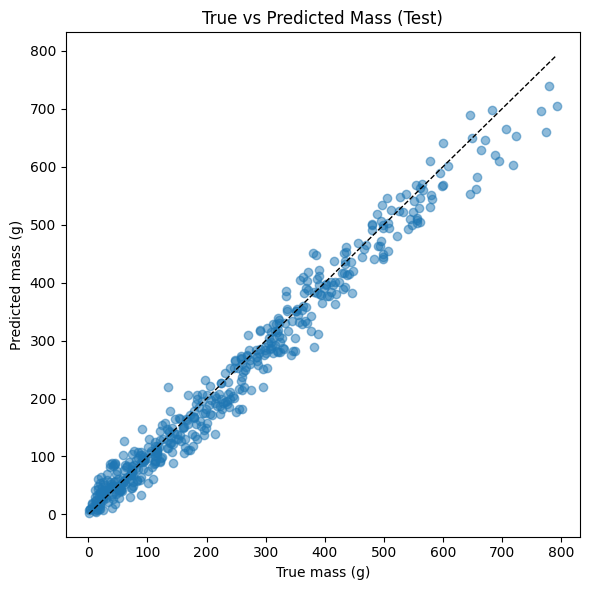

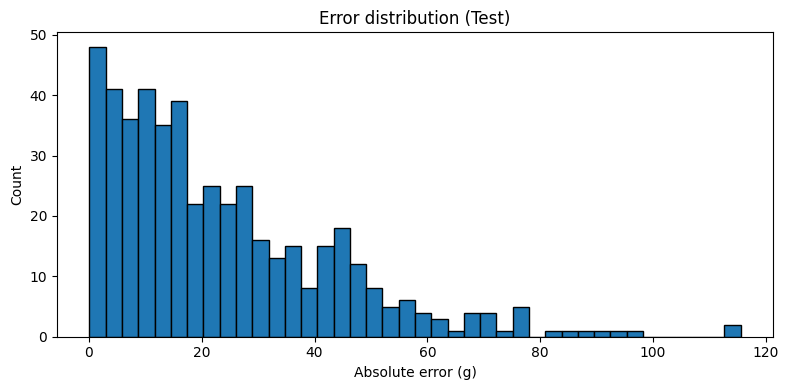

In [16]:
# ===========================================
# CELL 11: Simple plots for analysis (optional)
# ===========================================
print("results shape:", results.shape)
print("results columns:", list(results.columns))

plt.figure(figsize=(6, 6))
plt.scatter(results["true_mass_g"], results["pred_mass_g"], alpha=0.5)
min_val = min(results["true_mass_g"].min(), results["pred_mass_g"].min())
max_val = max(results["true_mass_g"].max(), results["pred_mass_g"].max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
plt.xlabel("True mass (g)")
plt.ylabel("Predicted mass (g)")
plt.title("True vs Predicted Mass (Test)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(results["abs_error_g"], bins=40, edgecolor="black")
plt.xlabel("Absolute error (g)")
plt.ylabel("Count")
plt.title("Error distribution (Test)")
plt.tight_layout()
plt.show()


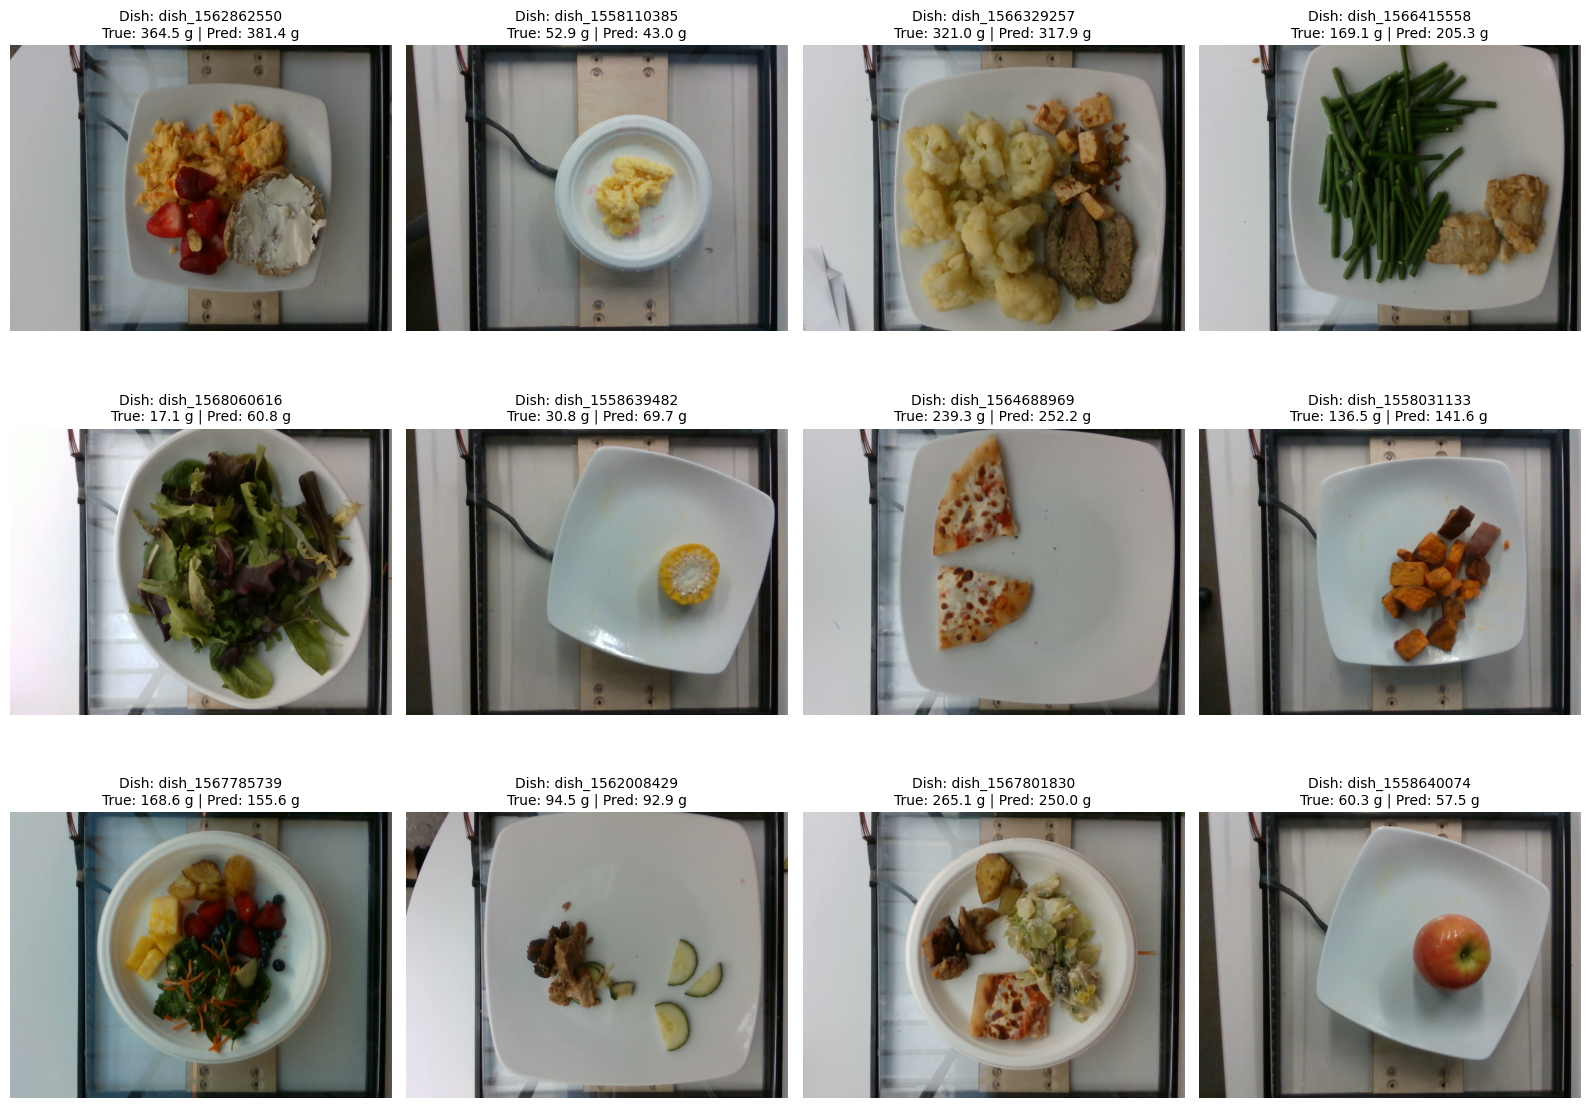

In [17]:
# ===========================================
# CELL 12: Visualize test images with true and predicted mass
# ===========================================
vis_df = results.copy()

N = 12
N = min(N, len(vis_df))

sample_df = vis_df.sample(N, random_state=SEED).reset_index(drop=True)

cols = 4
rows = int(np.ceil(N / cols))

plt.figure(figsize=(4 * cols, 4 * rows))

for idx in range(N):
    dish_id = str(sample_df.loc[idx, "dish_id"])
    true_m  = float(sample_df.loc[idx, "true_mass_g"])
    pred_m  = float(sample_df.loc[idx, "pred_mass_g"])

    img = load_rgb_from_pkl(dish_id)
    if img is None:
        img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color=(0, 0, 0))

    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        "Dish: {}\nTrue: {:.1f} g | Pred: {:.1f} g".format(dish_id, true_m, pred_m),
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [18]:
# ===========================================
# CELL 13: Save artifacts for follow-up notebook
# ===========================================
ARTIFACT_DIR = OUTPUT_DIR / "nutrition5k_mass_artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving artifacts to:", ARTIFACT_DIR)

# 1) Save trainval and test feature tables
trainval_path = ARTIFACT_DIR / "trainval_features.csv"
testfeat_path = ARTIFACT_DIR / "test_features.csv"

df_trainval.to_csv(trainval_path, index=False)
df_test.to_csv(testfeat_path, index=False)
print("Saved trainval features to:", trainval_path)
print("Saved test features to    :", testfeat_path)

# 2) Save indices of the split
train_idx_path = ARTIFACT_DIR / "train_indices.npy"
test_idx_path  = ARTIFACT_DIR / "test_indices.npy"

np.save(train_idx_path, train_idx)
np.save(test_idx_path, test_idx)
print("Saved train indices to:", train_idx_path)
print("Saved test indices to :", test_idx_path)

# 3) Save the tabular scaler
scaler_path = ARTIFACT_DIR / "tabular_scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print("Saved StandardScaler to:", scaler_path)

# 4) Save tabular feature names
tab_cols_path = ARTIFACT_DIR / "tabular_feature_names.txt"
with open(tab_cols_path, "w") as f:
    for col in tabular_cols:
        f.write(col + "\n")
print("Saved tabular feature names to:", tab_cols_path)

# 5) Build a test results table with mass predictions and meta information
macro_keywords = ["protein", "prot", "carb", "fat"]
macro_cols = [
    c for c in dishes_df.columns
    if any(k in c.lower() for k in macro_keywords)
]

macro_meta_cols = ["dish_id"] + macro_cols if macro_cols else ["dish_id"]
macro_meta = dishes_df[macro_meta_cols].copy()
macro_meta["dish_id"] = macro_meta["dish_id"].astype(str)

meta_for_join = meta.copy()
meta_for_join["dish_id"] = meta_for_join["dish_id"].astype(str)

results_for_join = results.copy()
results_for_join["dish_id"] = results_for_join["dish_id"].astype(str)

test_summary = (
    df_test[["dish_id"]].copy()
    .merge(results_for_join, on="dish_id", how="left")
    .merge(meta_for_join, on="dish_id", how="left", suffixes=("", "_meta"))
    .merge(macro_meta, on="dish_id", how="left")
)

test_summary_path = ARTIFACT_DIR / "test_mass_predictions_with_meta.csv"
test_summary.to_csv(test_summary_path, index=False)
print("Saved test mass predictions with meta to:", test_summary_path)

print("\nSummary for follow-up notebook:")
print("Rows in test_summary:", len(test_summary))
print("Columns in test_summary:", list(test_summary.columns))
print("Current best test MAE (this run): {:.2f} g".format(test_mae))
print("Model weights are saved at:", MODEL_PATH)
print("Raw prediction CSV is at  :", PRED_PATH)


Saving artifacts to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts
Saved trainval features to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/trainval_features.csv
Saved test features to    : /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/test_features.csv
Saved train indices to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/train_indices.npy
Saved test indices to : /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/test_indices.npy
Saved StandardScaler to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/tabular_scaler.pkl
Saved tabular feature names to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/tabular_feature_names.txt
Saved test mass predictions with meta to: /content/drive/MyDrive/Cal_Estimation_Project/Outputs/nutrition5k_mass_artifacts/test_mas

In [20]:
# ===========================================
# CELL 14: Save lightweight cache for fast re-runs
# ===========================================
cache_data = {
    "tabular_cols": tabular_cols,
    "train_size": len(df_trainval),
    "test_size": len(df_test),
    "results_shape": results.shape if "results" in globals() else None,
    "pred_csv": str(PRED_PATH),
    "model_path": str(MODEL_PATH),
    "artifact_dir": str(ARTIFACT_DIR),
    "best_test_mae": float(test_mae) if "test_mae" in globals() else None,
}

save_cache(cache_data, "06_part1_final")


✔ Saved cache → /content/drive/MyDrive/Cal_Estimation_Project/cache/06_part1_final.pkl
